# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [32]:
test_input_path = Path('/tmp/off-sample/test')
test_input_path

PosixPath('/tmp/off-sample/test')

In [33]:
def iter_dir(path):
    if path.is_dir():
        ch_paths = [iter_dir(ch) for ch in path.iterdir()]
        return [p for paths in ch_paths for p in paths]
    else:
        return [path]

In [34]:
image_paths = iter_dir(test_input_path)
len(image_paths)

1660

# Predict from Folder

In [2]:
import sklearn
from pathlib import Path

In [3]:
import fastai
import torch
fastai.__version__, torch.__version__

('1.0.48', '1.0.1.post2')

In [61]:
from fastai import *
from fastai.vision import *

In [70]:
torch.set_num_threads(8)
torch.get_num_threads()

In [ ]:
# %%time
export_fn = 'models/model.fai'
learn = load_learner('.', export_fn)

In [69]:
%%time
test_item_list = ImageList(image_paths)
learn.data.add_test(test_item_list)

pred_probs, _ = learn.get_preds(DatasetType.Test)
pred_probs = pred_probs.numpy()

CPU times: user 18min 24s, sys: 3min 8s, total: 21min 32s
Wall time: 1min 21s


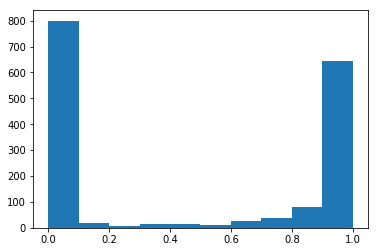

In [30]:
plt.hist(pred_probs[:,0]);

# Test Off Sample API

In [112]:
from requests import post
import json
import base64
from pathlib import Path
import shutil
from PIL import Image
import io

In [36]:
CHUNK_SIZE = 32

In [37]:
def make_image_paths_chunk_gen(image_paths, chunk_size):
    chunk_n = (len(image_paths) - 1) // chunk_size + 1
    image_path_chunks = [image_paths[i*chunk_size:(i+1)*chunk_size] for i in range(chunk_n)]
    
    for image_path_chunk in image_path_chunks:
        yield image_path_chunk

In [39]:
import base64

def convert_images_to_json(image_paths):
    base64_images = []
    for fp in image_paths:
        with open(fp, 'rb') as f:
            content = base64.b64encode(f.read()).decode()
            base64_images.append(content)
    doc = {
        'images': [{'content': content} for content in base64_images]
    }
    return doc

In [116]:
from requests import post, get

api_endpoint = 'http://localhost:9876'

def call_api(uri, doc=None):
    if doc:
        resp = post(url=api_endpoint + uri, json=doc, timeout=120)
    else:
        resp = get(url=api_endpoint + uri)
    if resp.status_code == 200:
        return resp.json()
    else:
        raise Exception(resp.content.decode())

In [ ]:
from time import sleep

while True:
    try:
        resp = call_api('/off-sample')
    except:
        print('Not ready...', end='\r')
    else:
        print(resp)
        break
    sleep(1)

In [106]:
def predict_chunk(image_paths_chunk):
    input_doc = convert_images_to_json(image_paths_chunk)
    resp_doc = call_api('/off-sample/predict', input_doc)
    return resp_doc['predictions']

In [107]:
%%time

from concurrent.futures import ThreadPoolExecutor

max_images = len(image_paths)
with ThreadPoolExecutor(8) as pool:
    futures = pool.map(predict_chunk, make_image_paths_chunk_gen(image_paths[:max_images], CHUNK_SIZE))
    predictions = list(p for preds in futures for p in preds)

CPU times: user 388 ms, sys: 62.4 ms, total: 451 ms
Wall time: 1min 21s


In [101]:
len(predictions)

1660

In [114]:
n = 5
predictions[:n] + predictions[-n:]

[{'prob': 0.941720724105835, 'label': 'off'},
 {'prob': 0.9403411149978638, 'label': 'off'},
 {'prob': 0.8537865877151489, 'label': 'off'},
 {'prob': 0.8300384879112244, 'label': 'off'},
 {'prob': 0.5911377668380737, 'label': 'off'},
 {'prob': 0.0006065397756174207, 'label': 'on'},
 {'prob': 0.0006643567467108369, 'label': 'on'},
 {'prob': 0.0030925970058888197, 'label': 'on'},
 {'prob': 1.6921954966164776e-06, 'label': 'on'},
 {'prob': 1.1536756574059837e-05, 'label': 'on'}]

Label: off, Off-sample probability: 0.942


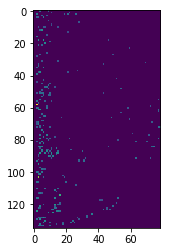

Label: off, Off-sample probability: 0.940


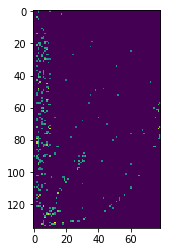

Label: off, Off-sample probability: 0.854


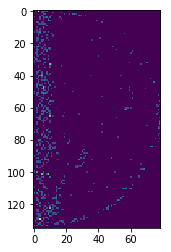

Label: off, Off-sample probability: 0.830


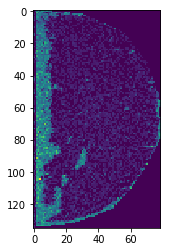

Label: off, Off-sample probability: 0.591


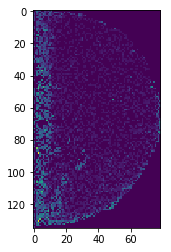

Label: on, Off-sample probability: 0.001


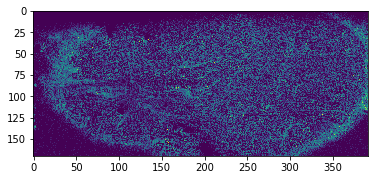

Label: on, Off-sample probability: 0.001


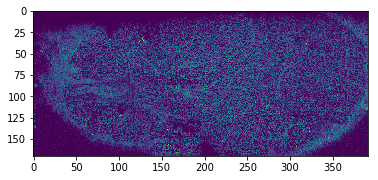

Label: on, Off-sample probability: 0.003


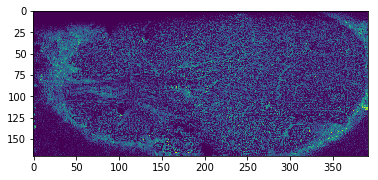

Label: on, Off-sample probability: 0.000


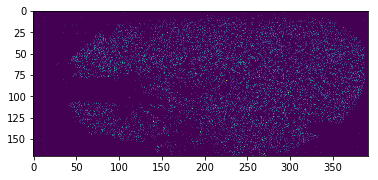

Label: on, Off-sample probability: 0.000


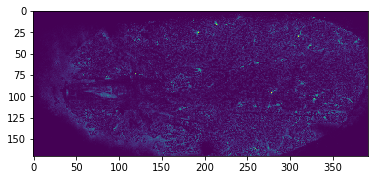

In [115]:
for img_path, pred in zip(image_paths[:n] + image_paths[-n:], predictions[:n] + predictions[-n:]):
    img = np.array(Image.open(open(img_path, 'rb')))[:,:,0]
    print(f'Label: {pred["label"]}, Off-sample probability: {pred["prob"]:.3f}')
    plt.imshow(img)
    plt.show()